In [9]:
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import math
import torch.nn as nn
from transformers import ViTForImageClassification
from torchvision import transforms

class GradCAM:
    def __init__(self, model):
        self.model = model.model
        self.target_layer = self.model.vit.encoder.layer[-1].output  # Last encoder block
        self.model.eval()
        
        self.gradients = []
        self.activations = []
        
        def save_gradient(grad):
            """Hook to capture gradients during backpropagation"""
            self.gradients.append(grad.detach())

        def save_activation(module, input, output):
            """Hook to capture activations during forward pass"""
            self.activations.append(output.detach())
            output.register_hook(save_gradient)  # Register hook on the output tensor
        
        # Register hooks
        self.target_layer.register_forward_hook(save_activation)

    def generate_cam(self, input_image, target_class=None):
        self.gradients = []
        self.activations = []
        
        image_tensor = input_image.unsqueeze(0).to(self.model.device)

        self.model.train()  # ✅ Enable train mode for correct backprop behavior

        # Forward pass
        output = self.model(image_tensor).logits
        pred_class = output.argmax(dim=1).item() if target_class is None else target_class

        # Clear gradients
        self.model.zero_grad()

        # Backward pass
        class_loss = output[0, pred_class]
        class_loss.backward()

        self.model.eval()  # ✅ Restore eval mode

        # Ensure gradients are non-zero
        gradients = self.gradients[0] if self.gradients else None
        if gradients is None or torch.all(gradients == 0):
            print("🚨 Gradients are still zero! Check target layer selection or backprop.")
            return None, pred_class
        else:
            print(f"✅ Non-zero gradients found! {gradients.shape}")

        # Get activations and gradients
        gradients = self.gradients[0]  # [1, 197, 768]
        activations = self.activations[0]  # [1, 197, 768]

        # Remove CLS token
        gradients = gradients[:, 1:, :]  # [1, 196, 768]
        activations = activations[:, 1:, :]  # [1, 196, 768]

        # Pool the gradients
        pooled_gradients = torch.mean(gradients, dim=[0, 1])  # [768]

        # Weight activations by importance scores
        for i in range(768):
            activations[:, :, i] *= pooled_gradients[i]

        # Average over the feature dimension
        cam = torch.mean(activations, dim=2).squeeze(0)  # [196]

        # Reshape to square (14x14)
        cam = cam.view(14, 14)

        # Normalize CAM
        cam = torch.maximum(cam, torch.tensor(0, device=self.model.device))
        if cam.max() != 0:
            cam = (cam - cam.min()) / (cam.max() - cam.min())

        # Resize to match input image
        cam = cam.cpu().numpy()
        cam = cv2.resize(cam, (input_image.shape[2], input_image.shape[1]))

        print(f"✅ Grad-CAM Successfully Generated for Class: {pred_class}")

        return cam, pred_class


class RetinalClassifier:
    def __init__(self, num_classes=5):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Load pre-trained model while ignoring classifier size mismatch
        self.model = ViTForImageClassification.from_pretrained(
            'google/vit-base-patch16-224',
            num_labels=num_classes,
            ignore_mismatched_sizes=True  # Prevents classifier size errors
        ).to(self.device)

        # Replace classifier layer
        self.model.classifier = torch.nn.Linear(self.model.config.hidden_size, num_classes).to(self.device)

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def predict(self, image_path):
        self.model.eval()
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(image).logits
            _, predicted = torch.max(outputs, 1)
            
        return predicted.item()


class RetinalExplainer:
    def __init__(self, classifier_model):
        self.grad_cam = GradCAM(classifier_model)
        self.model = classifier_model
        
    def explain(self, image_path, save_path=None):
        """Generate and optionally save explanation visualization"""
        image = Image.open(image_path).convert('RGB')
        preprocess = self.model.transform
        input_tensor = preprocess(image).to(self.model.model.device)
        
        # Generate CAM
        cam, pred_class = self.grad_cam.generate_cam(input_tensor)
        if cam is None:
            return None, pred_class
        
        # Convert CAM to heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        
        # Load original image and resize to match heatmap
        original_image = cv2.imread(image_path)
        original_image = cv2.resize(original_image, (cam.shape[1], cam.shape[0]))
        
        # Superimpose heatmap on original image
        superimposed_img = cv2.addWeighted(original_image, 0.7, heatmap, 0.3, 0)
        
        if save_path:
            cv2.imwrite(save_path, superimposed_img)
            
        return superimposed_img, pred_class

    def plot_explanation(self, image_path):
        """Plot original image, heatmap, and superimposed visualization"""
        superimposed_img, pred_class = self.explain(image_path)
        if superimposed_img is None:
            print("❌ Grad-CAM generation failed due to zero gradients.")
            return None

        original_image = cv2.imread(image_path)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        
        # Create figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Plot original image
        ax1.imshow(original_image)
        ax1.set_title('Original Image')
        ax1.axis('off')
        
        # Plot Grad-CAM visualization
        ax2.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
        ax2.set_title(f'Grad-CAM Visualization\nPredicted Class: {pred_class}')
        ax2.axis('off')
        
        plt.tight_layout()
        return fig


# ✅ Usage example
if __name__ == "__main__":
    model = RetinalClassifier()

    # Load model checkpoint
    checkpoint = torch.load('best_model.pth', map_location=torch.device('cpu'))

    # Remove classifier from checkpoint
    filtered_checkpoint = {k: v for k, v in checkpoint['model_state_dict'].items() if not k.startswith("classifier")}
    model.model.load_state_dict(filtered_checkpoint, strict=False)

    print("Checkpoint loaded successfully, classifier initialized randomly.")

    explainer = RetinalExplainer(model)
    
    # Generate explanation for an image
    fig = explainer.plot_explanation('/Users/tanishroy/Desktop/School/Third year/Retinal-Disease-Detection-main/APTOS 2019 Blindness Detection Segmented/train_images/0a4e1a29ffff.png')
    plt.show()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'math' is not defined

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Checkpoint loaded successfully, classifier initialized randomly.


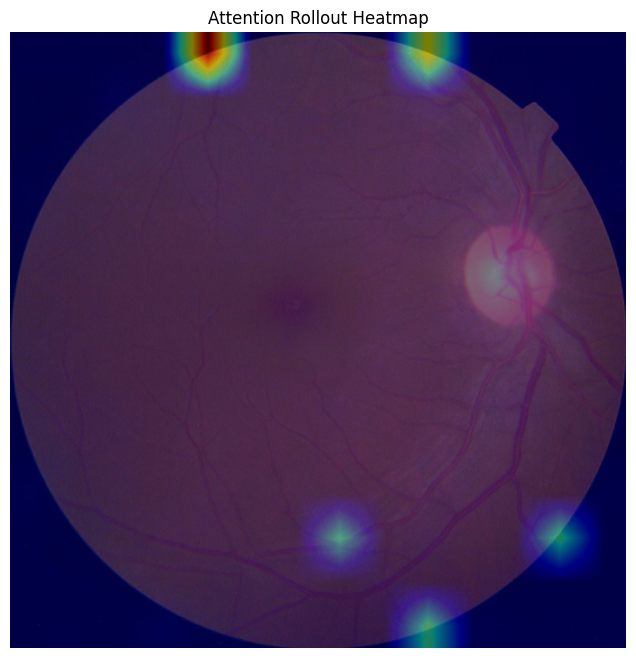

In [3]:
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import math
import torch.nn as nn
from transformers import ViTForImageClassification
from torchvision import transforms

class RetinalClassifier:
    def __init__(self, num_classes=5):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Load pre-trained model while ignoring classifier size mismatch
        self.model = ViTForImageClassification.from_pretrained(
            'google/vit-base-patch16-224',
            num_labels=num_classes,
            ignore_mismatched_sizes=True  # Prevents classifier size errors
        ).to(self.device)

        # Replace classifier layer
        self.model.classifier = torch.nn.Linear(self.model.config.hidden_size, num_classes).to(self.device)

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def predict(self, image_path):
        self.model.eval()
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(image).logits
            _, predicted = torch.max(outputs, 1)
            
        return predicted.item()


import torch
from PIL import Image
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt

def compute_attention_rollout(attentions, discard_ratio=0.0):
    """
    Computes the attention rollout from a tuple of attention matrices.
    
    Args:
        attentions (tuple): Attention matrices from each transformer block.
        discard_ratio (float): Fraction of the lowest attention weights to discard.
    
    Returns:
        result (torch.Tensor): The cumulative attention rollout.
    """
    # Initialize rollout as an identity matrix
    result = torch.eye(attentions[0].size(-1)).unsqueeze(0).to(attentions[0].device)
    
    for attention in attentions:
        # Average over all heads: [batch, seq_len, seq_len]
        attn_heads_fused = attention.mean(dim=1)
        # Add identity (to account for residual connections)
        attn_heads_fused = attn_heads_fused + torch.eye(attn_heads_fused.size(-1)).to(attn_heads_fused.device)
        # Normalize each row
        attn_heads_fused = attn_heads_fused / attn_heads_fused.sum(dim=-1, keepdim=True)
        
        # Optionally discard a portion of the lowest attention values
        if discard_ratio > 0:
            flat = attn_heads_fused.view(attn_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1) * discard_ratio), dim=-1, largest=False)
            flat.scatter_(1, indices, 0)
            attn_heads_fused = flat.view_as(attn_heads_fused)
        
        # Multiply the attention matrices
        result = torch.bmm(result, attn_heads_fused)
    return result

def explain_model(retinal_classifier, image_path, discard_ratio=0.0, visualize=True):
    """
    Generates an attention rollout heatmap for a given image using a loaded model.
    
    Args:
        retinal_classifier: An instance of your RetinalClassifier (with a loaded model).
        image_path (str): Path to the image to explain.
        discard_ratio (float): Fraction of the lowest attention weights to discard.
        visualize (bool): If True, display the heatmap overlay on the image.
    
    Returns:
        heatmap (numpy.ndarray): A 2D array representing the attention heatmap.
    """
    # Access the underlying ViT model from the classifier
    model = retinal_classifier.model
    model.eval()
    
    # Define a transform matching training (or inference) preprocessing
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    # Get the device from the model parameters
    device = next(model.parameters()).device
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Forward pass with attention outputs enabled
    outputs = model(input_tensor, output_attentions=True)
    attentions = outputs.attentions  # Tuple of attention matrices from each transformer block
    
    # Compute the cumulative attention rollout
    rollout = compute_attention_rollout(attentions, discard_ratio=discard_ratio)
    # Extract attention from the class token (assumed at index 0) to patch tokens (indices 1 onward)
    class_attention = rollout[0, 0, 1:]
    
    # For ViT base (patch size 16 on a 224x224 image) the grid is 14x14
    grid_size = int(class_attention.shape[0] ** 0.5)
    heatmap = class_attention.reshape(grid_size, grid_size).detach().cpu().numpy()
    
    if visualize:
        # Resize heatmap to the original image size for overlay using cv2
        heatmap_resized = cv2.resize(heatmap, image.size)
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.imshow(heatmap_resized, cmap='jet', alpha=0.5)
        plt.title("Attention Rollout Heatmap")
        plt.axis('off')
        plt.show()
    
    return heatmap

if __name__ == "__main__":
    from transformers.models.vit.configuration_vit import ViTConfig
    import torch

    torch.serialization.add_safe_globals([ViTConfig])


    # Create an instance of your classifier
    model = RetinalClassifier()

    # Load model checkpoint
    checkpoint = torch.load('/Users/devshah/Documents/WorkSpace/University/year 3/CSC490/Zero-Shot-Object-Tracking-FPS/classifier_model/Best Model.pth', map_location=torch.device('cpu'))
    # Remove classifier parameters from the checkpoint (if needed)
    filtered_checkpoint = {k: v for k, v in checkpoint['model_state_dict'].items() if not k.startswith("classifier")}
    model.model.load_state_dict(filtered_checkpoint, strict=False)
    print("Checkpoint loaded successfully, classifier initialized randomly.")

    # Path to the image you want to explain
    image_path = "/Users/devshah/Documents/WorkSpace/University/year 3/CSC490/Zero-Shot-Object-Tracking-FPS/APTOS 2019 Blindness Detection/train_images/0a09aa7356c0.png"
    # Generate and display the explanation heatmap
    heatmap = explain_model(model, image_path, discard_ratio=0.0, visualize=True)
